## Track the plasma motion

Cite this GitHub url: https://github.com/hayesla/DynaSun_workshop/blob/main/sunpy_dynasun_tutorial.ipynb

In [1028]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import sunpy.map
import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize, LogNorm
# from matplotlib.colorbar import ColorbarBase
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from astropy.visualization import ImageNormalize, SqrtStretch, LogStretch, AsymmetricPercentileInterval, AsinhStretch
import astropy.units as u
from astropy.coordinates import SkyCoord, SkyOffsetFrame
from scipy.interpolate import interp1d
from sunpy.coordinates import SphericalScreen
from scipy.stats import linregress
from sunpy.sun import constants as const
from tqdm import tqdm

import os
import sys
# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
if script_path not in sys.path:
    sys.path.append(script_path)

import solar_data_utils as myfuncs
# Reload to update with new changes
import importlib
importlib.reload(myfuncs)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

import matplotlib
import sunpy.visualization.colormaps as cm

sdoaia171 = matplotlib.colormaps['sdoaia171']
sdoaia193 = matplotlib.colormaps['sdoaia193']
sdoaia211 = matplotlib.colormaps['sdoaia211']
sdoaia304 = matplotlib.colormaps['sdoaia304']

data_dir = '/home/mnedal/data'

In [ ]:
dict_maps = {
    '171A': [],
    '193A': [],
    '211A': [],
    '304A': []
}

# AIA 304 &Aring;

In [172]:
start = '2024-05-14T17:00:00'
end   = '2024-05-14T18:59:00'
channel = 304
data_type = 'highres'

# Check if the datetime is a string
if isinstance(start, str) and isinstance(end, str):
    dt_dict = myfuncs.split_datetime(start=start, end=end)

# Check if the datetime is a pandas.Timestamp
elif isinstance(start, pd.Timestamp) and isinstance(end, pd.Timestamp):
    dt_dict = myfuncs.split_datetime(start=str(start).replace(' ','T'), end=str(end).replace(' ','T'))

data_path = f'{data_dir}/AIA/{channel}A/{data_type}/lv15'
data = sorted(glob.glob(f'{data_path}/aia*{channel}A_*.fits'))

start_pattern = f"aia*{channel}A_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}T{dt_dict['start_hour']}_{dt_dict['start_minute']}*"
end_pattern   = f"aia*{channel}A_{dt_dict['end_year']}_{dt_dict['end_month']}_{dt_dict['end_day']}T{dt_dict['end_hour']}_{dt_dict['end_minute']}*"

first_file_to_find = sorted(glob.glob(f'{data_path}/{start_pattern}*.fits'))
last_file_to_find  = sorted(glob.glob(f'{data_path}/{end_pattern}*.fits'))

idx1 = data.index(first_file_to_find[0])
idx2 = data.index(last_file_to_find[0])

chosen_files = data[idx1:idx2]

map_objects = []
with tqdm(total=len(chosen_files), desc='Loading the maps ...') as pbar:
    for i, file in enumerate(chosen_files):
        # load the file as a sunpy map
        m = sunpy.map.Map(file)
        map_objects.append(m)
        pbar.update(1)
        # print(f'AIA {channel}A lv1.5-image {i} is loaded')

Loading the maps ...: 100%|████████████████████████████████████████████████████████████████████| 592/592 [04:56<00:00,  2.00it/s]


In [174]:
len(map_objects), map_objects[0].meta['t_obs'], map_objects[-1].meta['t_obs']

(592, '2024-05-14T17:00:06.59Z', '2024-05-14T18:58:54.58Z')

In [ ]:
dict_maps['304A'] = map_objects

NameError: name 'slitt1' is not defined

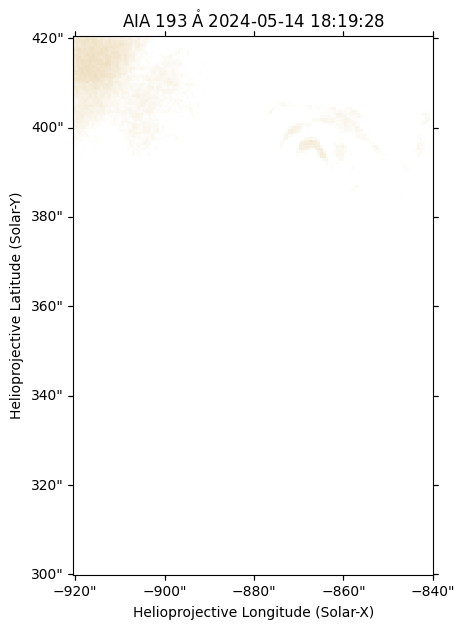

In [210]:
idx = 177
m = map_objects[idx]
norm = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch()) # SqrtStretch, LogStretch, AsinhStretch

# crop the region of interest
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)

# define a line over the vortex
slit = SkyCoord(
    Tx=[-877, -885]*u.arcsec,
    Ty=[385, 370]*u.arcsec,
    frame=m_submap.coordinate_frame
)

fig = plt.figure(figsize=[5,7])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)
ax.plot_coord(slit, color='white', ls=':', lw=3)

# Convert the slit coordinates to pixel coordinates for annotation
start_pix, end_pix = m_submap.world_to_pixel(slit)
x1pix, y1pix = start_pix.value
# x2pix, y2pix = end_pix
# Annotate at the tip of the slit using pixel coordinates
ax.annotate('1', xy=(x1pix, y1pix), xytext=(0,180),
            textcoords='offset points', color='w', fontsize=15)

# ax.grid(False)
fig.tight_layout()
plt.show()

In [81]:
# # take the slit coordinates and maps them onto the pixel grid of the solar image
# slit_pixelated = sunpy.map.pixelate_coord_path(m, slit)

# # how far the slit extends in terms of physical distance on the map
# slit_distance = slit_pixelated.separation(slit_pixelated[0])

In [98]:
# track how intensity evolves along the slit over the sequence of solar images
for m in map_objects:
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())

intensity_stack = []
with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
    for m in map_objects:
        with SphericalScreen(m.observer_coordinate):
            slit_pixelated = sunpy.map.pixelate_coord_path(m, slit)
        slit_distance = slit_pixelated.separation(_slit_pixelated[0])
        intensity = sunpy.map.sample_at_coords(m, _slit_pixelated)
        f_interp = interp1d(slit_distance.to_value('arcsec'), intensity.value, fill_value='extrapolate', kind='linear')
        intensity_interp = f_interp(slit_distance.to_value('arcsec'))
        intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
        pbar.update(1)

# intensity_stack = u.Quantity(intensity_stack)

# get the time array and the distance along slit in arcsec
time_array = [m.date.datetime for m in map_objects]
distance = slit_distance.to(u.arcsec)

Stack intensities ...: 100%|███████████████████████████████████████████████████████████████████| 592/592 [01:56<00:00,  5.09it/s]


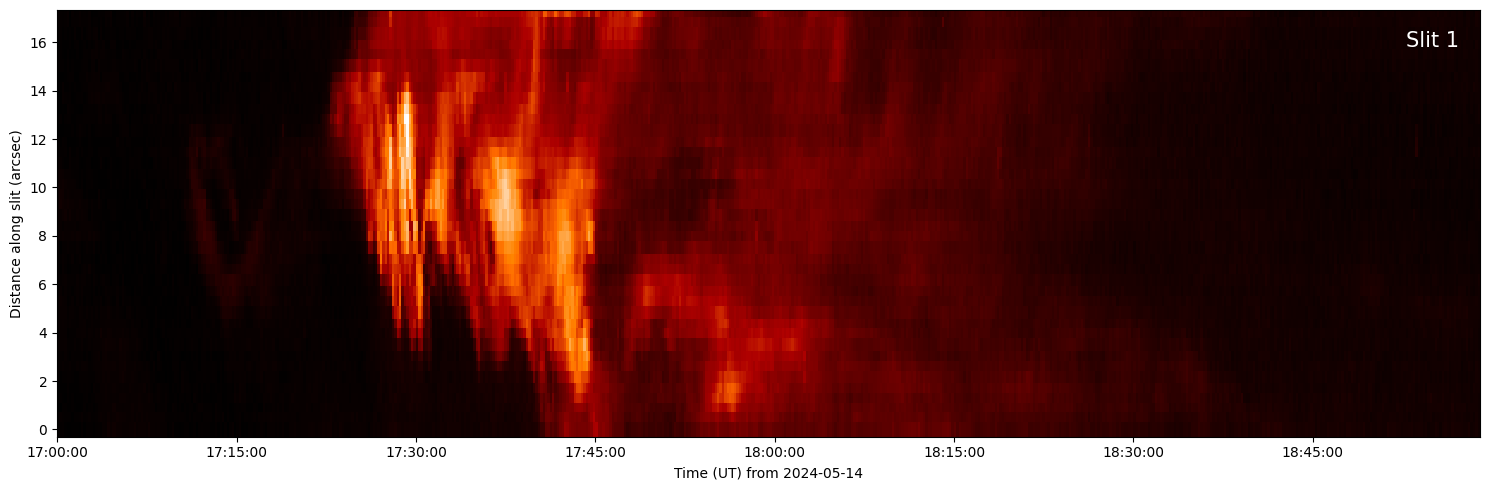

In [108]:
fig, ax = plt.subplots(figsize=[15,5])
ax.pcolormesh(time_array, distance.value, np.array(intensity_stack).T,
              norm=ImageNormalize(stretch=AsinhStretch()),
              cmap=sdoaia304
             )
ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
        fontsize=15, color='white', verticalalignment='top', horizontalalignment='right',
        # bbox=dict(facecolor='white', alpha=0.5)
       )
ax.set_ylabel('Distance along slit (arcsec)')
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()

In [ ]:
start_time = datetime(2024, 5, 14, 17, 18, 0)  # Replace with your actual start time
end_time = datetime(2024, 5, 14, 17, 48, 0)    # Replace with your actual end time
start_distance = 17.5                          # Replace with your actual start distance
end_distance = 0.5                             # Replace with your actual end distance

# get the radius of the solar disk
sol_rad = const.equatorial_radius.to(u.km)

# conversion factor from arcsec to km
conversion_factor = sol_rad/m_run.rsun_obs
print(conversion_factor)

# Convert datetime to numerical format (Matplotlib date format)
start_num = mdates.date2num(start_time)
end_num = mdates.date2num(end_time)

# Perform linear fit
slope, intercept, r_value, p_value, std_err = linregress([start_num, end_num],
                                                         [start_distance, end_distance])
# # convert distance from arcsec to km
# distance_km = distance * conversion_factor
# distance_diff_km = distance_km.diff()

# # calculate the time difference in seconds
# time_diff_s = time_array.diff().dt.total_seconds()

# # calculate the speed in km/s
# speed_km_s = distance_diff_km / time_diff_s
# print(speed_km_s)

# Generate x values (time) for plotting the fit line
fit_times = np.linspace(start_num, end_num, 100)

# Generate y values (distance) for the fit line using the linear equation
fit_distances = slope*fit_times + intercept

# Calculate speed (in arcseconds per second)
# Matplotlib's date2num function returns the number of days, so convert accordingly
time_diff_seconds = (end_time - start_time).total_seconds()
speed = ((end_distance - start_distance)*u.arcsec * conversion_factor) / (time_diff_seconds*u.second)
print(speed)

In [ ]:
# fig, ax = plt.subplots(figsize=[15,5])
# ax.pcolormesh(time_array, distance.value, intensity_stack.value.T,
#                # norm=ImageNormalize(stretch=AsinhStretch()),
#                # norm=norm,
#                cmap='Greys_r')
# ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
#         fontsize=15, color='crimson', verticalalignment='top', horizontalalignment='right',
#         bbox=dict(facecolor='white', alpha=0.5))

# # Plot the linear fit line
# ax.plot(fit_times, fit_distances, color='crimson', linestyle='--', linewidth=3, label=f'Linear fit: {speed.value:.2f} km/s')
# ax.legend(loc='lower right')
# ax.set_ylabel('Distance along slit (arcsec)')
# ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
# plt.show()

distance_Mm = (distance * conversion_factor).value/1e3
fit_distance_Mm = (fit_distances * conversion_factor).value/1e3



fig = plt.figure(figsize=[15,4])
ax = fig.add_subplot(121, projection=m_run)
m_run.plot(axes=ax, cmap='Greys_r', norm=norm)
ax.plot_coord(traced_loop, color='crimson', lw=2)

# Convert the slit coordinates to pixel coordinates for annotation
start_pix, end_pix = m_run.world_to_pixel(traced_loop)
x1pix, y1pix = start_pix
x2pix, y2pix = end_pix
# Annotate at the tip of the slit using pixel coordinates
ax.annotate('1', xy=(x1pix.value, y1pix.value), xytext=(0,45), textcoords='offset points', color='crimson', fontsize=15)
ax.grid(False)

ax = fig.add_subplot(122)
# ax.pcolormesh(time_array, distance_Mm, intensity_stack.value.T, cmap='Greys_r')
ax.pcolormesh(time_array, distance_Mm, np.array(intensity_stack).T, cmap='Greys_r')
ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
        fontsize=15, color='crimson', verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.5))

# Plot the linear fit line
ax.plot(fit_times, fit_distance_Mm, color='crimson', linestyle='--', linewidth=3, label=f'Linear fit: {speed.value:.2f} km/s')
ax.legend(loc='lower right')
ax.set_ylabel('Distance (Mm)')
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

fig.tight_layout()
plt.show()

In [ ]:
# Temoplate ...
fig = plt.figure(figsize=[20,6])

# Define the grid layout
# 1st column: 1 row, 1 column
# 2nd column: 4 rows, 2 columns
# We'll use GridSpec to manage the layout
from matplotlib.gridspec import GridSpec

# Create a GridSpec with 4 rows and 3 columns
gs = GridSpec(4, 3, figure=fig)

# Add the first subplot (full height of the first column)
ax1 = fig.add_subplot(gs[:, 0])
ax1.set_title('Left Column')

# Add subplots for the second column (4 rows x 2 columns)
ax2 = fig.add_subplot(gs[0, 1:2])
ax3 = fig.add_subplot(gs[1, 1:2])
ax4 = fig.add_subplot(gs[2, 1:2])
ax5 = fig.add_subplot(gs[3, 1:2])

# Add subplots for the third column (4 rows x 2 columns)
ax6 = fig.add_subplot(gs[0, 2:])
ax7 = fig.add_subplot(gs[1, 2:])
ax8 = fig.add_subplot(gs[2, 2:])
ax9 = fig.add_subplot(gs[3, 2:])

# Titles for each subplot in the second and third columns
ax2.set_title('Middle Column, Row 1')
ax3.set_title('Middle Column, Row 2')
ax4.set_title('Middle Column, Row 3')
ax5.set_title('Middle Column, Row 4')

ax6.set_title('Right Column, Row 1')
ax7.set_title('Right Column, Row 2')
ax8.set_title('Right Column, Row 3')
ax9.set_title('Right Column, Row 4')

fig.tight_layout()
plt.show()

# AIA 171 &Aring;

In [116]:
channel = 171

# Check if the datetime is a string
if isinstance(start, str) and isinstance(end, str):
    dt_dict = myfuncs.split_datetime(start=start, end=end)

# Check if the datetime is a pandas.Timestamp
elif isinstance(start, pd.Timestamp) and isinstance(end, pd.Timestamp):
    dt_dict = myfuncs.split_datetime(start=str(start).replace(' ','T'), end=str(end).replace(' ','T'))

data_path = f'{data_dir}/AIA/{channel}A/{data_type}/lv15'
data = sorted(glob.glob(f'{data_path}/aia*{channel}A_*.fits'))

start_pattern = f"aia*{channel}A_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}T{dt_dict['start_hour']}_{dt_dict['start_minute']}*"
end_pattern   = f"aia*{channel}A_{dt_dict['end_year']}_{dt_dict['end_month']}_{dt_dict['end_day']}T{dt_dict['end_hour']}_{dt_dict['end_minute']}*"

first_file_to_find = sorted(glob.glob(f'{data_path}/{start_pattern}*.fits'))
last_file_to_find  = sorted(glob.glob(f'{data_path}/{end_pattern}*.fits'))

idx1 = data.index(first_file_to_find[0])
idx2 = data.index(last_file_to_find[0])

chosen_files = data[idx1:idx2]

map_objects = []
with tqdm(total=len(chosen_files), desc=f'Loading AIA {channel}A maps ...') as pbar:
    for i, file in enumerate(chosen_files):
        # load the file as a sunpy map
        m = sunpy.map.Map(file)
        map_objects.append(m)
        pbar.update(1)

Loading AIA 171A maps ...: 100%|███████████████████████████████████████████████████████████████| 582/582 [01:43<00:00,  5.61it/s]


In [117]:
len(map_objects), map_objects[0].meta['t_obs'], map_objects[-1].meta['t_obs']

(582, '2024-05-14T17:00:10.34Z', '2024-05-14T18:58:58.35Z')

In [119]:
dict_maps['171A'] = map_objects

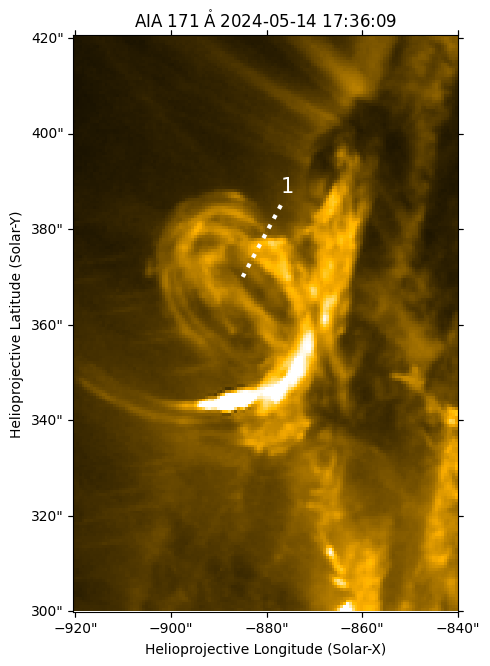

In [130]:
idx = 177
m = map_objects[idx]
norm = ImageNormalize(vmin=0, vmax=7e3, stretch=AsinhStretch())

# crop the region of interest
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)

# define a line over the vortex
slit = SkyCoord(
    Tx=[-877, -885]*u.arcsec,
    Ty=[385, 370]*u.arcsec,
    frame=m_submap.coordinate_frame
)

fig = plt.figure(figsize=[5,7])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)
ax.plot_coord(slit, color='white', ls=':', lw=3)

# Convert the slit coordinates to pixel coordinates for annotation
start_pix, end_pix = m_submap.world_to_pixel(slit)
x1pix, y1pix = start_pix.value
# Annotate at the tip of the slit using pixel coordinates
ax.annotate('1', xy=(x1pix, y1pix), xytext=(0,180),
            textcoords='offset points', color='w', fontsize=15)
ax.grid(False)
fig.tight_layout()
plt.show()

In [127]:
# track how intensity evolves along the slit over the sequence of solar images
for m in map_objects:
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=7e3, stretch=AsinhStretch())

intensity_stack = []
with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
    for m in map_objects:
        with SphericalScreen(m.observer_coordinate):
            _slit_pixelated = sunpy.map.pixelate_coord_path(m, slit)
        _slit_distance = _slit_pixelated.separation(_slit_pixelated[0])
        intensity = sunpy.map.sample_at_coords(m, _slit_pixelated)
        f_interp = interp1d(_slit_distance.to_value('arcsec'), intensity.value, fill_value='extrapolate', kind='linear')
        intensity_interp = f_interp(slit_distance.to_value('arcsec'))
        intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
        pbar.update(1)

# get the time array and the distance along slit in arcsec
time_array = [m.date.datetime for m in map_objects]
distance = slit_distance.to(u.arcsec)

Stack intensities ...: 100%|███████████████████████████████████████████████████████████████████| 582/582 [02:52<00:00,  3.38it/s]


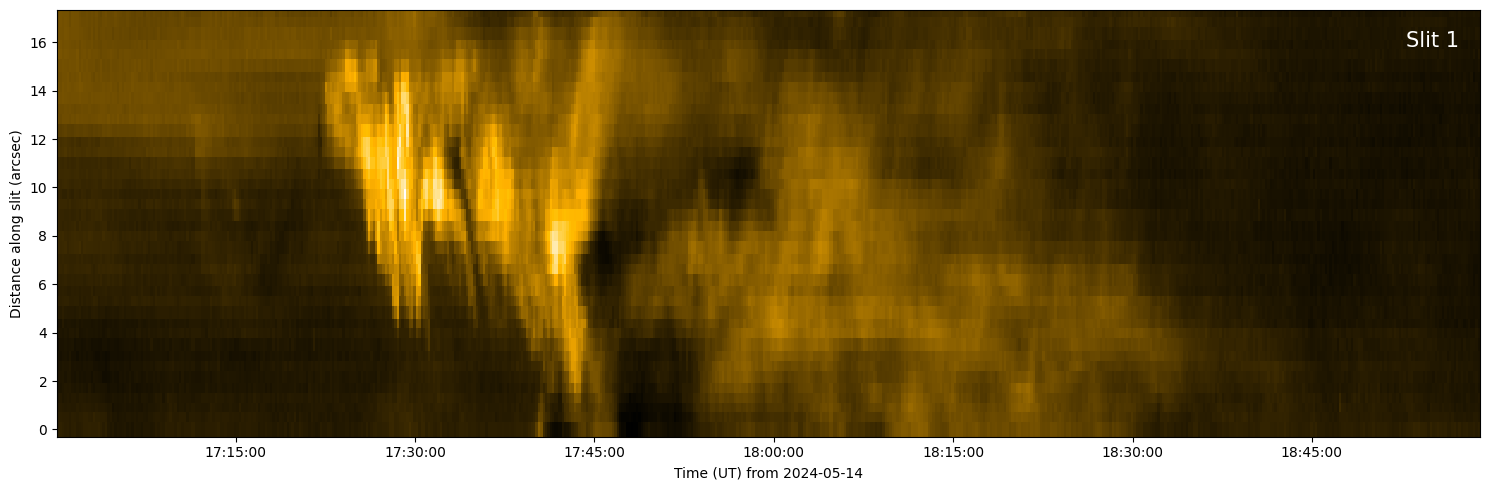

In [129]:
fig, ax = plt.subplots(figsize=[15,5])
ax.pcolormesh(time_array, distance.value, np.array(intensity_stack).T,
              norm=ImageNormalize(stretch=AsinhStretch()),
              cmap=sdoaia171)
ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
        fontsize=15, color='white', verticalalignment='top', horizontalalignment='right')
ax.set_ylabel('Distance along slit (arcsec)')
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()

# AIA 193 &Aring;

In [176]:
channel = 193

# Check if the datetime is a string
if isinstance(start, str) and isinstance(end, str):
    dt_dict = myfuncs.split_datetime(start=start, end=end)

# Check if the datetime is a pandas.Timestamp
elif isinstance(start, pd.Timestamp) and isinstance(end, pd.Timestamp):
    dt_dict = myfuncs.split_datetime(start=str(start).replace(' ','T'), end=str(end).replace(' ','T'))

data_path = f'{data_dir}/AIA/{channel}A/{data_type}/lv15'
data = sorted(glob.glob(f'{data_path}/aia*{channel}A_*.fits'))

start_pattern = f"aia*{channel}A_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}T{dt_dict['start_hour']}_{dt_dict['start_minute']}*"
end_pattern   = f"aia*{channel}A_{dt_dict['end_year']}_{dt_dict['end_month']}_{dt_dict['end_day']}T{dt_dict['end_hour']}_{dt_dict['end_minute']}*"

first_file_to_find = sorted(glob.glob(f'{data_path}/{start_pattern}*.fits'))
last_file_to_find  = sorted(glob.glob(f'{data_path}/{end_pattern}*.fits'))

idx1 = data.index(first_file_to_find[0])
idx2 = data.index(last_file_to_find[0])

chosen_files = data[idx1:idx2]

map_objects = []
with tqdm(total=len(chosen_files), desc=f'Loading AIA {channel}A maps ...') as pbar:
    for i, file in enumerate(chosen_files):
        # load the file as a sunpy map
        m = sunpy.map.Map(file)
        map_objects.append(m)
        pbar.update(1)

Loading AIA 193A maps ...: 100%|███████████████████████████████████████████████████████████████| 254/254 [00:35<00:00,  7.10it/s]


In [177]:
len(map_objects), map_objects[0].meta['t_obs'], map_objects[-1].meta['t_obs']

(254, '2024-05-14T17:00:07.23Z', '2024-05-14T18:58:17.84Z')

In [188]:
dict_maps['193A'] = map_objects

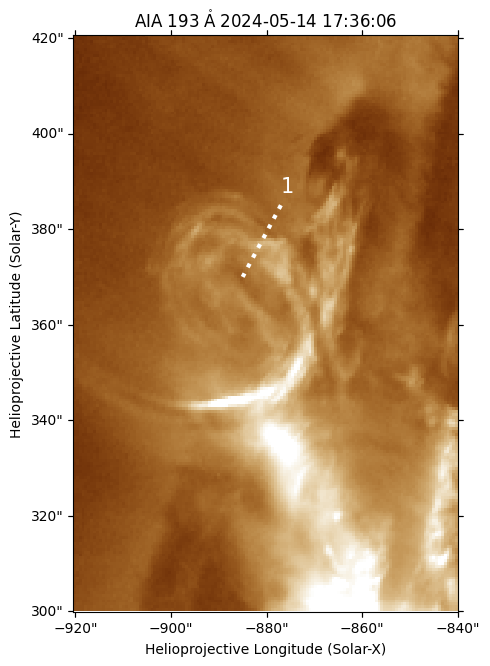

In [184]:
idx = 71
m = map_objects[idx]
norm = ImageNormalize(vmin=0, vmax=8e3, stretch=AsinhStretch())

# crop the region of interest
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)

# define a line over the vortex
slit = SkyCoord(
    Tx=[-877, -885]*u.arcsec,
    Ty=[385, 370]*u.arcsec,
    frame=m_submap.coordinate_frame
)

fig = plt.figure(figsize=[5,7])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)
ax.plot_coord(slit, color='white', ls=':', lw=3)

# Convert the slit coordinates to pixel coordinates for annotation
start_pix, end_pix = m_submap.world_to_pixel(slit)
x1pix, y1pix = start_pix.value
# Annotate at the tip of the slit using pixel coordinates
ax.annotate('1', xy=(x1pix, y1pix), xytext=(0,180),
            textcoords='offset points', color='w', fontsize=15)
ax.grid(False)
fig.tight_layout()
plt.show()

In [185]:
# track how intensity evolves along the slit over the sequence of solar images
for m in map_objects:
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=8e3, stretch=AsinhStretch())

intensity_stack = []
with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
    for m in map_objects:
        with SphericalScreen(m.observer_coordinate):
            _slit_pixelated = sunpy.map.pixelate_coord_path(m, slit)
        _slit_distance = _slit_pixelated.separation(_slit_pixelated[0])
        intensity = sunpy.map.sample_at_coords(m, _slit_pixelated)
        f_interp = interp1d(_slit_distance.to_value('arcsec'), intensity.value, fill_value='extrapolate', kind='linear')
        intensity_interp = f_interp(slit_distance.to_value('arcsec'))
        intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
        pbar.update(1)

# get the time array and the distance along slit in arcsec
time_array = [m.date.datetime for m in map_objects]
distance = slit_distance.to(u.arcsec)

Stack intensities ...: 100%|███████████████████████████████████████████████████████████████████| 254/254 [00:56<00:00,  4.46it/s]


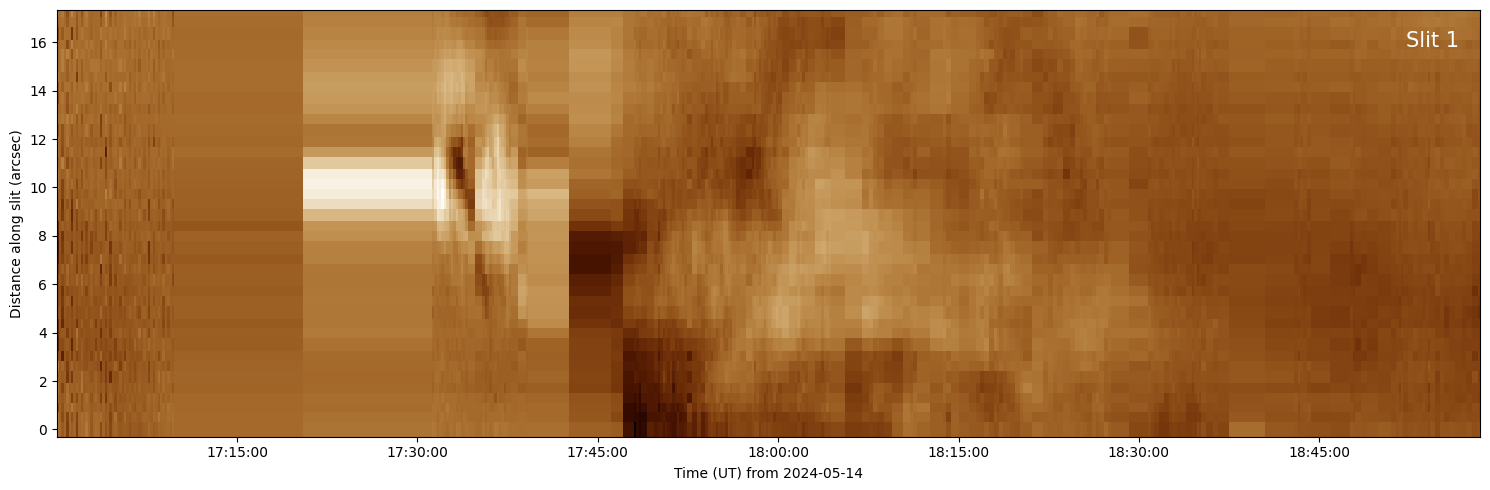

In [189]:
fig, ax = plt.subplots(figsize=[15,5])
ax.pcolormesh(time_array, distance.value, np.array(intensity_stack).T,
              norm=ImageNormalize(stretch=AsinhStretch()),
              cmap=sdoaia193)
ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
        fontsize=15, color='white', verticalalignment='top', horizontalalignment='right')
ax.set_ylabel('Distance along slit (arcsec)')
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()

# AIA 211 &Aring;

In [132]:
channel = 211

# Check if the datetime is a string
if isinstance(start, str) and isinstance(end, str):
    dt_dict = myfuncs.split_datetime(start=start, end=end)

# Check if the datetime is a pandas.Timestamp
elif isinstance(start, pd.Timestamp) and isinstance(end, pd.Timestamp):
    dt_dict = myfuncs.split_datetime(start=str(start).replace(' ','T'), end=str(end).replace(' ','T'))

data_path = f'{data_dir}/AIA/{channel}A/{data_type}/lv15'
data = sorted(glob.glob(f'{data_path}/aia*{channel}A_*.fits'))

start_pattern = f"aia*{channel}A_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}T{dt_dict['start_hour']}_{dt_dict['start_minute']}*"
end_pattern   = f"aia*{channel}A_{dt_dict['end_year']}_{dt_dict['end_month']}_{dt_dict['end_day']}T{dt_dict['end_hour']}_{dt_dict['end_minute']}*"

first_file_to_find = sorted(glob.glob(f'{data_path}/{start_pattern}*.fits'))
last_file_to_find  = sorted(glob.glob(f'{data_path}/{end_pattern}*.fits'))

idx1 = data.index(first_file_to_find[0])
idx2 = data.index(last_file_to_find[0])

chosen_files = data[idx1:idx2]

map_objects = []
with tqdm(total=len(chosen_files), desc=f'Loading AIA {channel}A maps ...') as pbar:
    for i, file in enumerate(chosen_files):
        # load the file as a sunpy map
        m = sunpy.map.Map(file)
        map_objects.append(m)
        pbar.update(1)

Loading AIA 211A maps ...: 100%|███████████████████████████████████████████████████████████████| 452/452 [02:01<00:00,  3.71it/s]


In [133]:
len(map_objects), map_objects[0].meta['t_obs'], map_objects[-1].meta['t_obs']

(452, '2024-05-14T17:00:13.21Z', '2024-05-14T18:58:59.08Z')

In [134]:
dict_maps['211A'] = map_objects

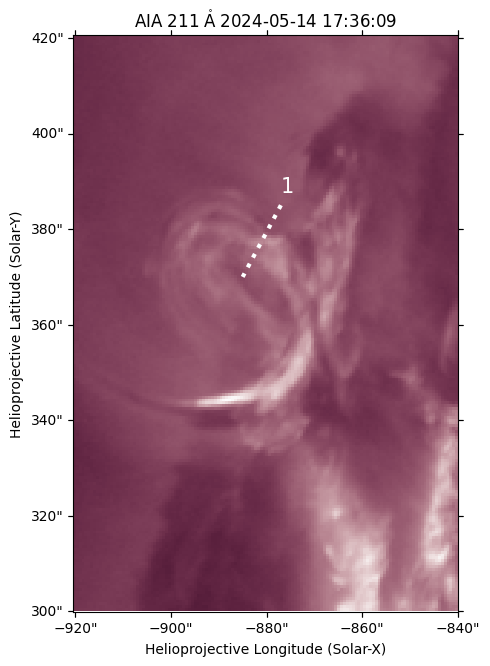

In [147]:
idx = 126
m = map_objects[idx]
norm = ImageNormalize(vmin=0, vmax=5e3, stretch=AsinhStretch())

# crop the region of interest
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)

# define a line over the vortex
slit = SkyCoord(
    Tx=[-877, -885]*u.arcsec,
    Ty=[385, 370]*u.arcsec,
    frame=m_submap.coordinate_frame
)

fig = plt.figure(figsize=[5,7])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)
ax.plot_coord(slit, color='white', ls=':', lw=3)

# Convert the slit coordinates to pixel coordinates for annotation
start_pix, end_pix = m_submap.world_to_pixel(slit)
x1pix, y1pix = start_pix.value
# Annotate at the tip of the slit using pixel coordinates
ax.annotate('1', xy=(x1pix, y1pix), xytext=(0,180),
            textcoords='offset points', color='w', fontsize=15)
ax.grid(False)
fig.tight_layout()
plt.show()

In [148]:
# track how intensity evolves along the slit over the sequence of solar images
for m in map_objects:
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5e3, stretch=AsinhStretch())

intensity_stack = []
with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
    for m in map_objects:
        with SphericalScreen(m.observer_coordinate):
            _slit_pixelated = sunpy.map.pixelate_coord_path(m, slit)
        _slit_distance = _slit_pixelated.separation(_slit_pixelated[0])
        intensity = sunpy.map.sample_at_coords(m, _slit_pixelated)
        f_interp = interp1d(_slit_distance.to_value('arcsec'), intensity.value, fill_value='extrapolate', kind='linear')
        intensity_interp = f_interp(slit_distance.to_value('arcsec'))
        intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
        pbar.update(1)

# get the time array and the distance along slit in arcsec
time_array = [m.date.datetime for m in map_objects]
distance = slit_distance.to(u.arcsec)

Stack intensities ...: 100%|███████████████████████████████████████████████████████████████████| 452/452 [02:01<00:00,  3.71it/s]


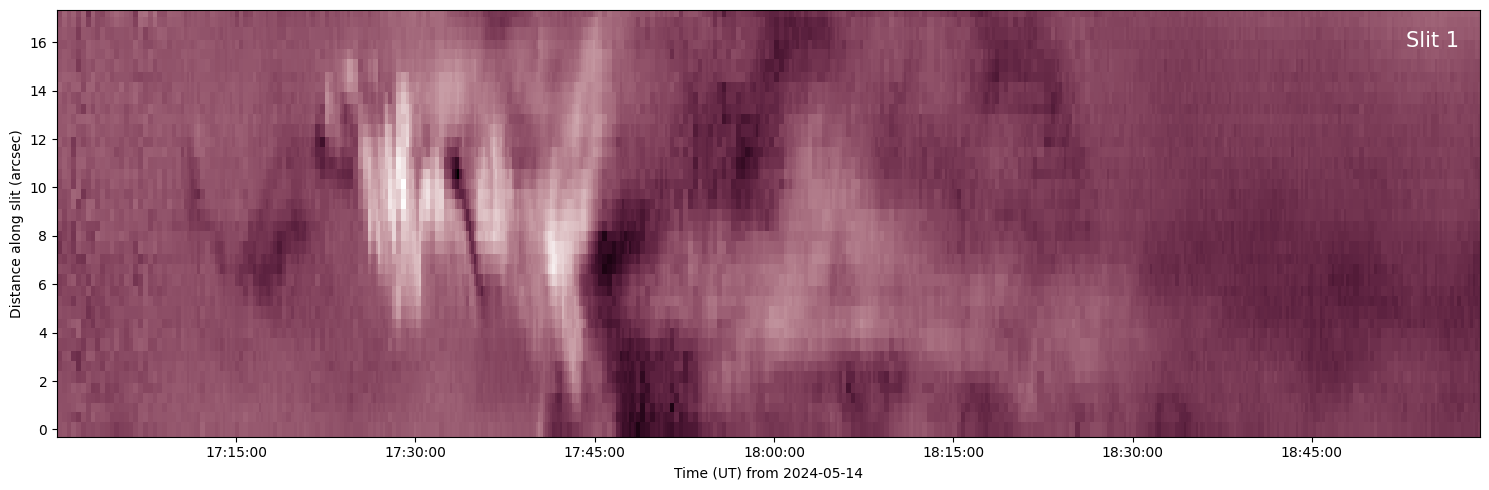

In [149]:
fig, ax = plt.subplots(figsize=[15,5])
ax.pcolormesh(time_array, distance.value, np.array(intensity_stack).T,
              norm=ImageNormalize(stretch=AsinhStretch()),
              cmap=sdoaia211)
ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
        fontsize=15, color='white', verticalalignment='top', horizontalalignment='right')
ax.set_ylabel('Distance along slit (arcsec)')
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()

In [171]:
print(len(dict_maps['171A']))
print(len(dict_maps['193A']))
print(len(dict_maps['211A']))
print(len(dict_maps['304A']))

582
0
452
592


# Make composite RGB maps

In [198]:
from skimage.transform import resize

In [199]:
dict_maps['171A'][177].data.shape, dict_maps['193A'][71].data.shape, dict_maps['211A'][126].data.shape, dict_maps['304A'][177].data.shape

((4094, 4094), (4096, 4096), (4096, 4096), (4096, 4096))

In [205]:
def enhance_contrast(image, vmin, vmax):
    """
    Enhance contrast by clipping and normalization.
    """
    image_clipped = np.clip(image, vmin, vmax)
    image_normalized = (image_clipped - vmin) / (vmax - vmin)
    return image_normalized


def calculate_percentiles(image, lower_percentile=3, upper_percentile=97):
    """
    Calculate vmin and vmax based on the 1st and 99th percentiles.
    """
    vmin = np.percentile(image, lower_percentile)
    vmax = np.percentile(image, upper_percentile)
    return vmin, vmax

In [440]:
m1 = dict_maps['171A'][177]
m2 = dict_maps['193A'][71]
m3 = dict_maps['211A'][126]

enhanced = False

# Determine the target shape (smallest shape among the three images)
target_shape = (min(m1.data.shape[0], m2.data.shape[0], m3.data.shape[0]),
                min(m1.data.shape[1], m2.data.shape[1], m3.data.shape[1]))

# Resize each image to the target shape
m1_resized = resize(m1.data, target_shape, preserve_range=True)
m2_resized = resize(m2.data, target_shape, preserve_range=True)
m3_resized = resize(m3.data, target_shape, preserve_range=True)

# Stack the resized images
rgb_image = np.stack([m1_resized, m2_resized, m3_resized], axis=-1)

In [441]:
# Normalize the data
m1_resized = (m1_resized - np.min(m1_resized)) / (np.max(m1_resized) - np.min(m1_resized))
m2_resized = (m2_resized - np.min(m2_resized)) / (np.max(m2_resized) - np.min(m2_resized))
m3_resized = (m3_resized - np.min(m3_resized)) / (np.max(m3_resized) - np.min(m3_resized))

# Stack the resized images into an RGB composite (each map corresponds to one color channel)
rgb_image = np.stack([m1_resized, m2_resized, m3_resized], axis=-1)

In [428]:
if enhanced:
    # Enhance contrast for each channel
    rgb_image_enhanced = np.zeros_like(rgb_image)
    for i in range(3):  # Process each channel independently
        vmin, vmax = calculate_percentiles(rgb_image[..., i])
        rgb_image_enhanced[..., i] = enhance_contrast(rgb_image[..., i], vmin, vmax)
    # Convert the 3D array to a 2D array by averaging the channels
    array_2d = np.mean(rgb_image_enhanced, axis=2)
else:
    # Convert the 3D array to a 2D array by averaging the channels
    array_2d = np.mean(rgb_image, axis=2)

# Create a SunPy map with the resulting array
m_rgb = sunpy.map.Map(array_2d, m1.meta)

In [450]:
# rgb = sunpy.map.Map(array_2d, m1.meta)
rgb_image.shape

(4094, 4094, 3)

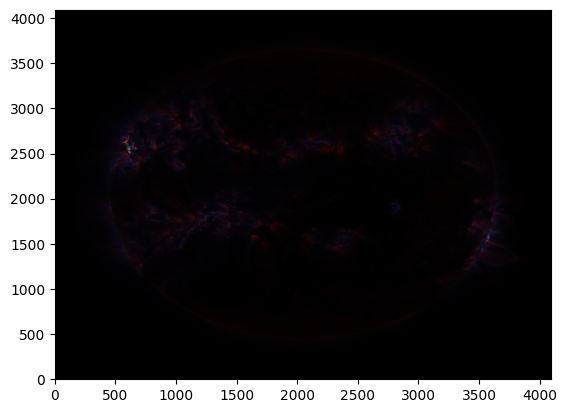

In [449]:
# Display the composite image
fig, ax = plt.subplots()
ax.imshow(rgb_image, aspect='auto', origin='lower')
plt.show()

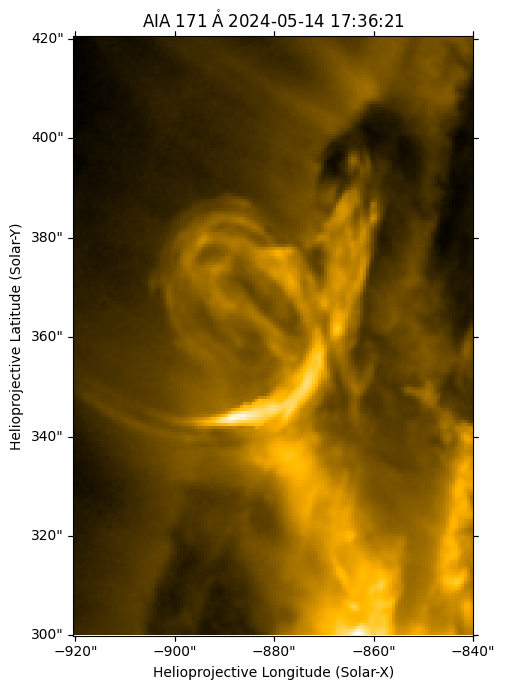

In [424]:
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m_rgb.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m_rgb.coordinate_frame)
m_rgb_submap = m_rgb.submap(bottom_left, top_right=top_right)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(projection=m_rgb_submap)
m_rgb_submap.plot(axes=ax, norm=LogNorm())
ax.grid(False)
fig.tight_layout()
plt.show()

In [1202]:
# m = map_objects[177]
# top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
# bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
# m_submap = m.submap(bottom_left, top_right=top_right)

In [270]:
# %matplotlib widget
# %matplotlib notebook
%matplotlib inline

# Plot multiple slits

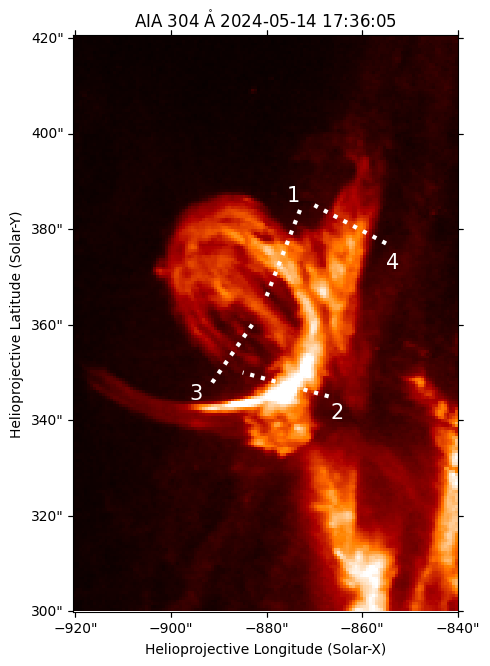

In [272]:
idx = 177
map_objects = dict_maps['304A']
m = map_objects[idx]
norm = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())

# crop the region of interest
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)

# define a line over the vortex
slit1 = SkyCoord(
    Tx=[-867, -885]*u.arcsec,
    Ty=[345, 350]*u.arcsec,
    frame=m_submap.coordinate_frame
)

slit2 = SkyCoord(
    Tx=[-873, -880]*u.arcsec,
    Ty=[384, 366]*u.arcsec,
    frame=m_submap.coordinate_frame
)

slit3 = SkyCoord(
    Tx=[-883, -892]*u.arcsec,
    Ty=[360, 347]*u.arcsec,
    frame=m_submap.coordinate_frame
)

slit4 = SkyCoord(
    Tx=[-855, -870]*u.arcsec,
    Ty=[377, 385]*u.arcsec,
    frame=m_submap.coordinate_frame
)

fig = plt.figure(figsize=[5,7])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)
ax.plot_coord(slit1, color='white', ls=':', lw=3)
ax.plot_coord(slit2, color='white', ls=':', lw=3)
ax.plot_coord(slit3, color='white', ls=':', lw=3)
ax.plot_coord(slit4, color='white', ls=':', lw=3)

# Convert the slit coordinates to pixel coordinates for annotation
# Annotate at the tip of the slit using pixel coordinates
start_pix, end_pix = m_submap.world_to_pixel(slit1)
xpix, ypix = start_pix.value
ax.annotate('1', xy=(xpix, ypix), xytext=(-30,174), textcoords='offset points', color='w', fontsize=15)

start_pix, end_pix = m_submap.world_to_pixel(slit2)
xpix, ypix = start_pix.value
ax.annotate('2', xy=(xpix, ypix), xytext=(22,0), textcoords='offset points', color='w', fontsize=15)

start_pix, end_pix = m_submap.world_to_pixel(slit3)
xpix, ypix = start_pix.value
ax.annotate('3', xy=(xpix, ypix), xytext=(-45,55), textcoords='offset points', color='w', fontsize=15)

start_pix, end_pix = m_submap.world_to_pixel(slit4)
xpix, ypix = start_pix.value
ax.annotate('4', xy=(xpix, ypix), xytext=(0,74), textcoords='offset points', color='w', fontsize=15)

ax.grid(False)
fig.tight_layout()
plt.show()

In [ ]:
# track how intensity evolves along the slit over the sequence of solar images
for m in map_objects:
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())

slits = [slit1, slit2, slit3, slit4]

for i, slit in enumerate(slits):
    intensity_stack = []
    with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
        for m in map_objects:
            with SphericalScreen(m.observer_coordinate):
                _slit_pixelated = sunpy.map.pixelate_coord_path(m, slit)
            _slit_distance = _slit_pixelated.separation(_slit_pixelated[0])
            intensity = sunpy.map.sample_at_coords(m, _slit_pixelated)
            f_interp = interp1d(_slit_distance.to_value('arcsec'), intensity.value, fill_value='extrapolate', kind='linear')
            intensity_interp = f_interp(slit_distance.to_value('arcsec'))
            intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
            pbar.update(1)
    
    # get the time array and the distance along slit in arcsec
    time_array = [m.date.datetime for m in map_objects]
    distance = slit_distance.to(u.arcsec)
    
    fig, ax = plt.subplots(figsize=[15,5])
    ax.pcolormesh(time_array, distance.value, np.array(intensity_stack).T,
                  norm=ImageNormalize(stretch=AsinhStretch()),
                  cmap=sdoaia304)
    ax.text(0.985, 0.95, f'Slit {i+1}', transform=ax.transAxes,
            fontsize=15, color='white', verticalalignment='top', horizontalalignment='right')
    ax.set_ylabel('Distance along slit (arcsec)')
    ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    fig.tight_layout()
    plt.show()

In [283]:
np.array(time_array).shape, distance.shape, np.array(intensity_stack).T.shape

((592,), (40,), (40, 592))

In [312]:
# track how intensity evolves along the slit over the sequence of solar images
for m in map_objects:
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())

intensity_stack = []
with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
    for m in map_objects:
        with SphericalScreen(m.observer_coordinate):
            _slit_pixelated = sunpy.map.pixelate_coord_path(m, slit1)
        _slit_distance = _slit_pixelated.separation(_slit_pixelated[0])
        intensity = sunpy.map.sample_at_coords(m, _slit_pixelated)
        f_interp = interp1d(_slit_distance.to_value('arcsec'), intensity.value, fill_value='extrapolate', kind='linear')
        intensity_interp = f_interp(slit_distance.to_value('arcsec'))
        intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
        pbar.update(1)

Stack intensities ...: 100%|███████████████████████████████████████████████████████████████████| 592/592 [01:38<00:00,  5.98it/s]


In [413]:
# get the time array and the distance along slit in arcsec
time_array = np.array([m.date.datetime for m in map_objects])
distance = slit_distance.to(u.arcsec).value
data = np.array(intensity_stack).T

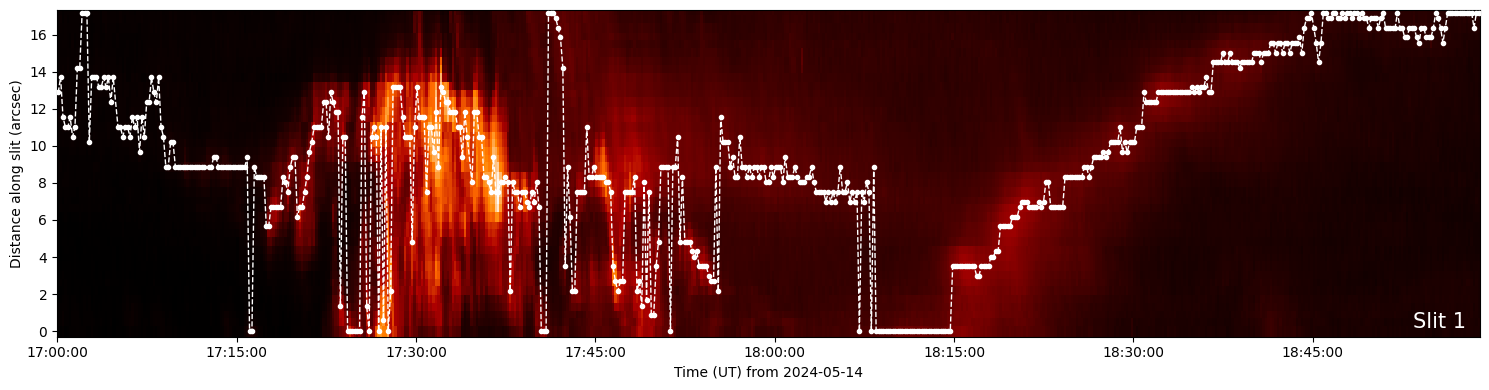

In [987]:
# Find the indices of the maximum values for each line curve
max_indices = np.argmax(data, axis=0)

fig, ax = plt.subplots(figsize=[15,4])
ax.pcolormesh(time_array, distance, data,
              norm=ImageNormalize(stretch=AsinhStretch()),
              # norm=LogNorm(),
              cmap=sdoaia304)
ax.text(0.99, 0.075, 'Slit 1', transform=ax.transAxes,
        fontsize=15, color='white', verticalalignment='top', horizontalalignment='right')
ax.set_ylabel('Distance along slit (arcsec)')
ax.plot(time_array, distance[max_indices], 'o--', color='w', lw=1, ms=3, zorder=5)
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()

In [984]:
# aia_map.plot(axes=ax, clip_interval=(1, 99.8) * u.percent)

In [985]:
# aia_rotated.world_to_pixel(rectangle).x
# m_submap.wcs.world_to_pixel(rectangle_corners[0])

In [922]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import cv2
import sunpy.data.sample
import sunpy.map


def draw_rectangle(center=(0, 0), width=1, height=1, angle=0):
    """
    Function to draw a rotated rectangle and return its corners.
    Inputs:
    =======
    center : Center of the rectangle
    width, height : Width and height of the rectangle
    angle : Rotation angle in degrees
    """
    # Generate rectangle corners (without rotation)
    half_width, half_height = width / 2, height / 2
    rectangle = np.array([
        [-half_width, -half_height],
        [half_width, -half_height],
        [half_width, half_height],
        [-half_width, half_height]
    ])
    # Rotation matrix
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    # Rotate the rectangle
    rotated_rectangle = rectangle @ rotation_matrix.T
    # Translate to the center point
    rotated_rectangle += np.array(center)
    return rotated_rectangle


def crop_rotated_rectangle(image, center, width, height, angle):
    """
    Function to extract the pixels inside the rotated rectangle using OpenCV.
    """
    # Get the rectangle's corner points
    rotated_rectangle = draw_rectangle(center, width, height, angle)
    # Compute the affine transform matrix to warp the image
    # We need three points from the rotated rectangle and their corresponding locations in a new axis-aligned rectangle
    src_pts = np.float32(rotated_rectangle[:3])  # Three points from the rotated rectangle
    dst_pts = np.float32([[0, 0], [width, 0], [width, height]])  # Mapped to a straight rectangle
    # Get the affine transformation matrix
    M = cv2.getAffineTransform(src_pts, dst_pts)
    # Apply the affine transformation to warp the image
    cropped_image = cv2.warpAffine(image, M, (int(width), int(height)))
    return cropped_image

In [915]:
def crop_rotated_rectangle(image, center, width, height, angle):
    """
    Function to extract the pixels inside the rotated rectangle using OpenCV.
    """
    # Get the rectangle's corner points
    rotated_rectangle = draw_rectangle(center, width, height, angle)
    
    # Create a mesh grid for the target coordinates (output image)
    xx, yy = np.meshgrid(np.arange(width), np.arange(height))
    
    # Compute the rotation matrix
    theta = np.radians(angle)
    inverse_rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    # Translate the mesh grid to the center and apply rotation
    xy_grid = np.vstack([xx.ravel() - width / 2, yy.ravel() - height / 2])  # Center the grid
    rotated_grid = inverse_rotation_matrix @ xy_grid  # Apply the rotation
    
    # Step 5: Translate the grid back to the original image's coordinate system
    rotated_grid[0, :] += center[0]  # X-coordinates
    rotated_grid[1, :] += center[1]  # Y-coordinates

    # Interpolate the pixel values using scipy's map_coordinates
    rotated_grid = rotated_grid.reshape(2, height, width)  # Reshape back into 2D grid
    cropped_image = scipy.ndimage.map_coordinates(image, [rotated_grid[1], rotated_grid[0]], order=1, mode='reflect')
    
    return cropped_image

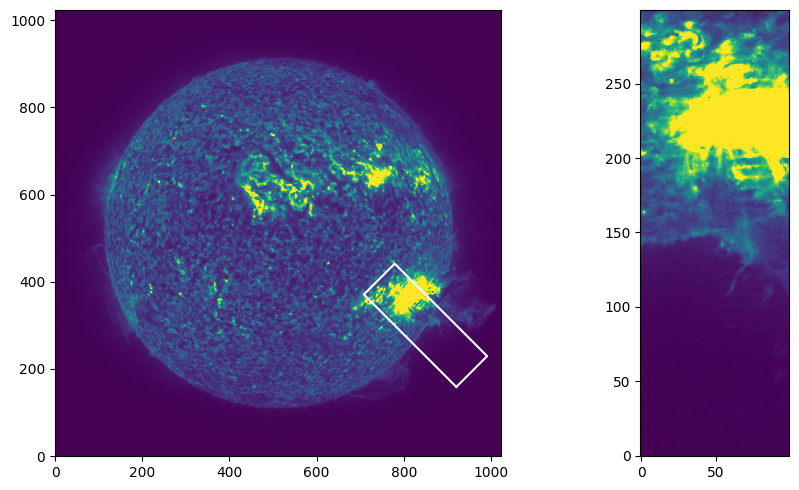

In [927]:
# usage
center = (850, 300)
width  = 100
height = 300
angle  = 45

rotated_rectangle = draw_rectangle(center=center, width=width, height=height, angle=angle)
aia_map = sunpy.map.Map(sunpy.data.sample.AIA_304_IMAGE)
image = aia_map.data

# Crop the rotated rectangle region
cropped_image = crop_rotated_rectangle(image, center=center, width=width, height=height, angle=angle)

fig = plt.figure(figsize=[10,5])
# Plot the original image with the rotated rectangle
ax = fig.add_subplot(121)
ax.imshow(image, origin='lower', vmin=0, vmax=3e2)
ax.plot(*zip(*np.vstack([rotated_rectangle, rotated_rectangle[0]])), color='w')
# Plot the cropped result
ax = fig.add_subplot(122)
ax.imshow(cropped_image, origin='lower', vmin=0, vmax=3e2)
fig.tight_layout()
plt.show()

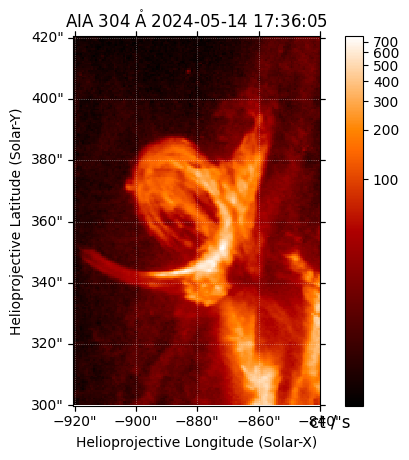

In [918]:
m_submap.peek()

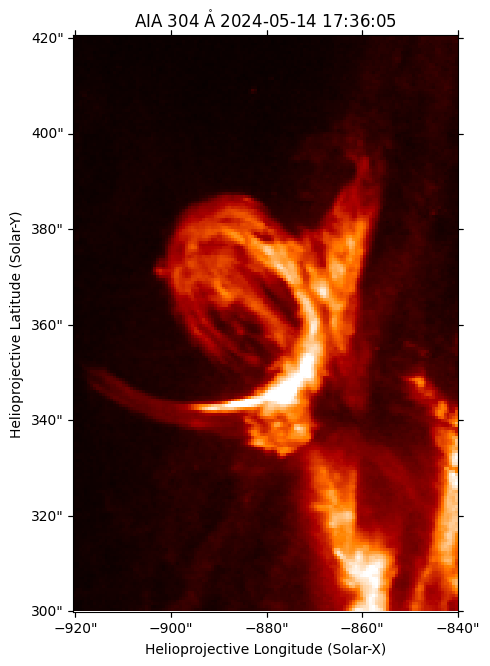

In [1004]:
fig = plt.figure(figsize=[5,7])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)
ax.grid(False)
fig.tight_layout()
plt.show()

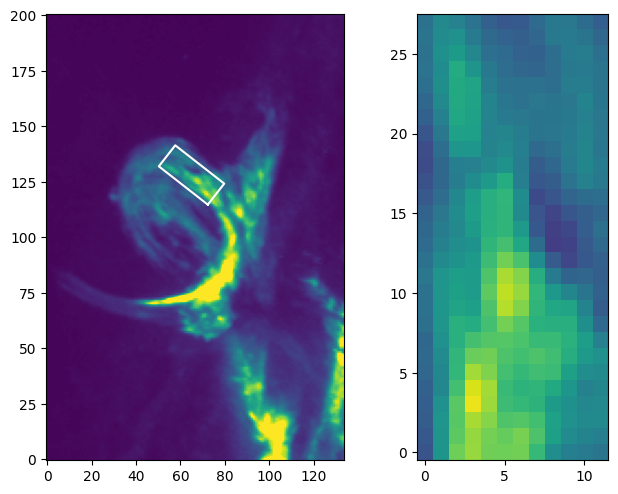

In [979]:
# usage
center = (65, 128)
width  = 12
height = 28
angle  = 52

rotated_rectangle = draw_rectangle(center=center, width=width, height=height, angle=angle)
image = m_submap.data.astype(np.float64)

# Crop the rotated rectangle region
cropped_image = crop_rotated_rectangle(image, center=center, width=width, height=height, angle=angle)

fig = plt.figure(figsize=[7,5])
# Plot the original image with the rotated rectangle
ax = fig.add_subplot(121)
ax.imshow(image, origin='lower', vmin=0, vmax=4e2)
ax.plot(*zip(*np.vstack([rotated_rectangle, rotated_rectangle[0]])), color='w')
# Plot the cropped result
ax = fig.add_subplot(122)
ax.imshow(cropped_image, origin='lower', vmin=0, vmax=4e2)
fig.tight_layout()
plt.show()

In [980]:
# Sum the pixel values over the columns into a 1D array (one column)
summed_pixels = np.sum(cropped_image, axis=1)
summed_pixels

array([2854.56024101, 2953.44501712, 2967.01708767, 2939.6929144 ,
       2918.19135188, 2964.28295414, 3014.21378464, 2940.89626966,
       2842.91670206, 2817.69133381, 2749.2966052 , 2569.96638595,
       2265.32266709, 2042.9045226 , 1983.99496587, 1957.20281292,
       1988.97193015, 1947.40064981, 1902.59585696, 1986.19472351,
       2062.80834161, 2076.24210707, 2092.33328205, 2077.44142422,
       1990.95194759, 1916.6525001 , 1844.89672218, 1738.49635985])

In [981]:
cropped_image.shape

(28, 12)

In [982]:
summed_pixels.shape

(28,)

In [1026]:
# plt.plot(summed_pixels)
# plt.show()

In [991]:
intensity_stack = []
with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
    for m in map_objects:
        image = m.data.astype(np.float64)
        cropped_image = crop_rotated_rectangle(image, center=center, width=width, height=height, angle=angle)
        summed_pixels = np.sum(cropped_image, axis=1)
        intensity_stack.append(summed_pixels)
        pbar.update(1)

Stack intensities ...: 100%|███████████████████████████████████████████████████████████████████| 592/592 [13:58<00:00,  1.42s/it]


In [1014]:
concatenated_array = np.vstack(intensity_stack)
print(concatenated_array.shape)  # Output will be (10, 28), assuming you have 10 arrays

(592, 28)


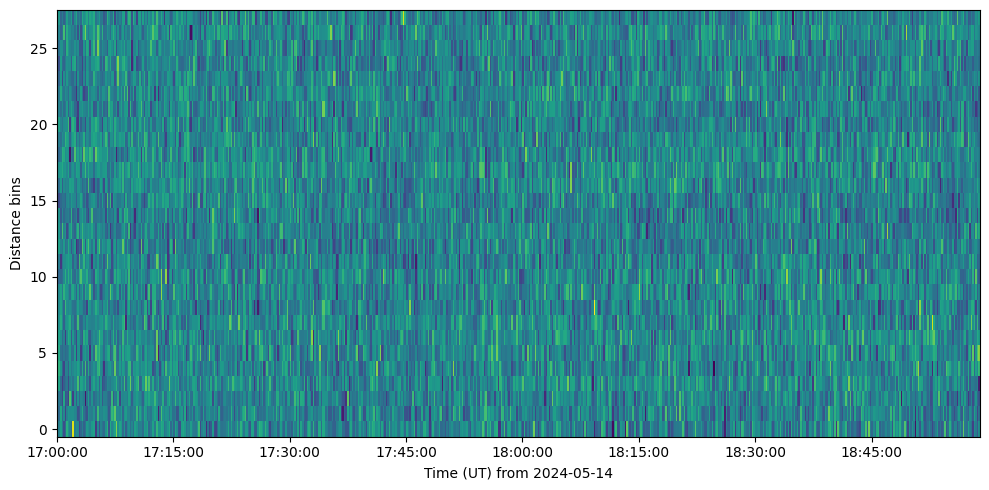

In [1025]:
fig, ax = plt.subplots(figsize=[10,5])
ax.pcolormesh(time_array,
              np.arange(concatenated_array.shape[1]),
              concatenated_array.T,
              # norm=ImageNormalize(stretch=AsinhStretch()),
              # norm=LogNorm(),
              # cmap=sdoaia304
             )
ax.set_ylabel('Distance bins')
# ax.set_ylabel('Distance along slit (arcsec)')
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()

## Do a semi-cericular loop over the vortex and extract the intensities and stack them in a 2D array

In [1041]:
# fig = plt.figure(figsize=[7,10])
# ax = fig.add_subplot(projection=aia_map)
# aia_map.plot(axes=ax, norm=norm)
# ax.minorticks_on()
# aia_map.draw_grid(grid_spacing=10*u.deg)
# fig.tight_layout()
# plt.show()

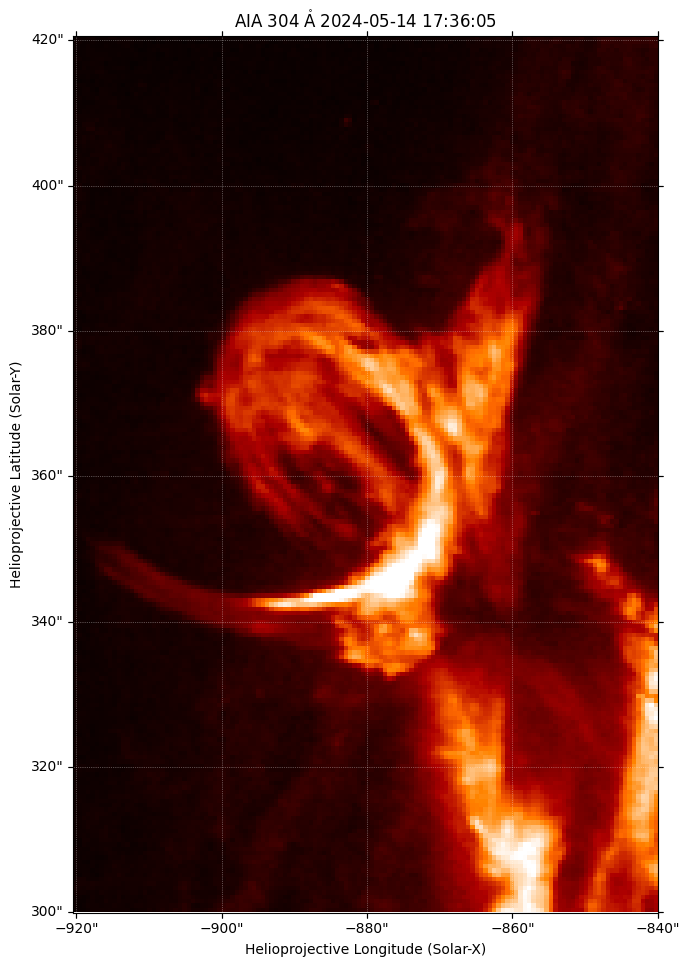

In [1042]:
fig = plt.figure(figsize=[7,10])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)
fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=[7,10])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)
fig.tight_layout()
plt.show()

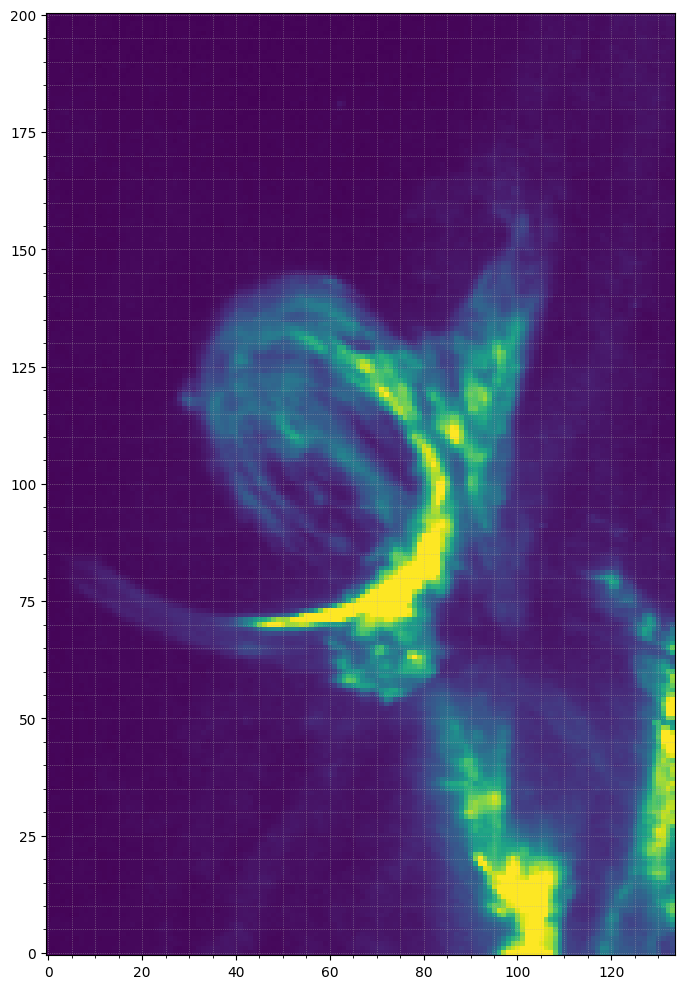

In [1051]:
subimage = m_submap.data.astype(np.float64)

fig = plt.figure(figsize=[7,10])
ax = fig.add_subplot(111)
ax.imshow(subimage, origin='lower', vmin=0, vmax=4e2)
ax.minorticks_on()
ax.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)
fig.tight_layout()
plt.show()

In [ ]:
def draw_quadratic_bezier(x1=0, y1=0, x2=0, y2=0, control=[0,0]):
    """
    Draw a Quadratic Bezier curve using the given control points.
    The curve will be drawn from the point (x1, y1) to the point
    (x2, y2) using the control points (control[0], control[1]).
    """
    # Convert points to numpy arrays
    P0 = np.array([x1, y1])  # Start point
    P1 = np.array(control)    # Control point
    P2 = np.array([x2, y2])   # End point

    # Create time steps t from 0 to 1
    t = np.linspace(0, 1, 50)  # 100 points for smoothness

    # Quadratic Bézier formula: B(t) = (1-t)^2 * P0 + 2*(1-t)*t * P1 + t^2 * P2
    bezier_curve = (1 - t)[:, None] ** 2 * P0 + \
                   2 * (1 - t)[:, None] * t[:, None] * P1 + \
                   t[:, None] ** 2 * P2

    return bezier_curve

def extract_quadratic_bezier_values(array, x1, y1, x2, y2, control):
    """
    Extract the values of a Bezier curve at the given control points.
    The curve will be drawn from the point (x1, y1) to the point
    (x2, y2) using the control points (control[0], control[1]).
    """
    bezier_curve = draw_quadratic_bezier(x1, y1, x2, y2, control)
    
    # Get the x and y coordinates
    x_coords = np.round(bezier_curve[:, 0]).astype(int)
    y_coords = np.round(bezier_curve[:, 1]).astype(int)

    # Clip the coordinates to stay within array bounds
    x_coords = np.clip(x_coords, 0, array.shape[1] - 1)
    y_coords = np.clip(y_coords, 0, array.shape[0] - 1)

    # Extract values along the Bézier curve
    bezier_values = array[y_coords, x_coords]
    
    return bezier_values, x_coords, y_coords





# Example usage in your plot
x1 = 80
y1 = 110
x2 = 50
y2 = 90
control = [40, 160]

fig = plt.figure(figsize=[7,10])
ax = fig.add_subplot(111)
ax.imshow(subimage, origin='lower', vmin=0, vmax=4e2)
_, x_coords, y_coords = extract_quadratic_bezier_values(subimage, x1, y1, x2, y2, control)
ax.plot(x_coords, y_coords, 'ko--', linewidth=1, markersize=3)
ax.minorticks_on()
ax.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)
fig.tight_layout()
plt.show()

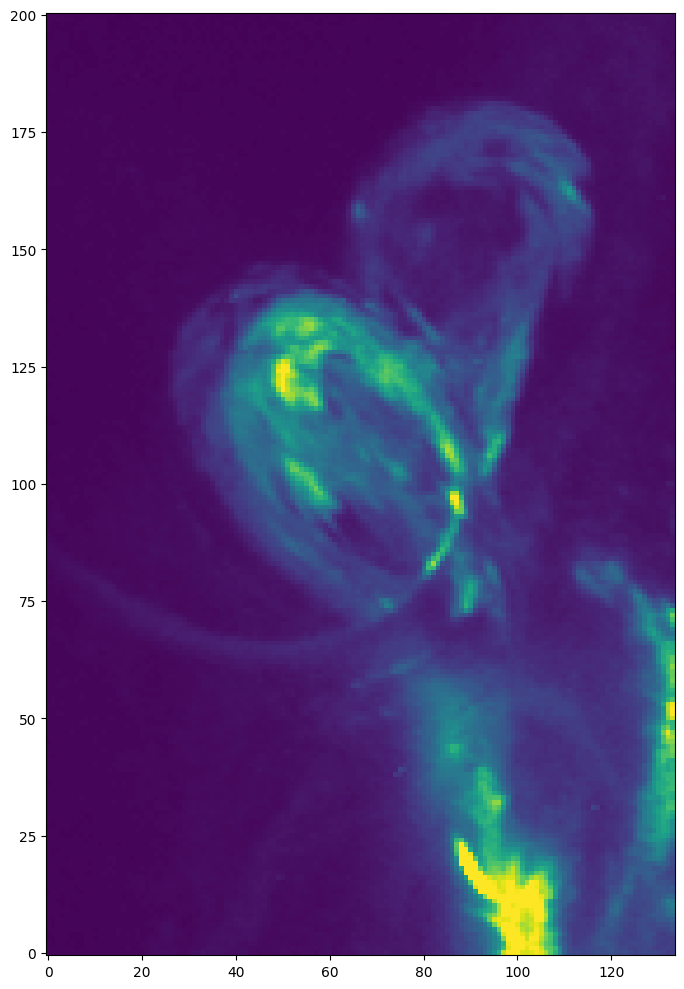

In [1374]:
m = map_objects[200]
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)
subimage = m_submap.data.astype(np.float64)

fig = plt.figure(figsize=[7,10])
ax = fig.add_subplot(111)
ax.imshow(subimage, origin='lower', vmin=0, vmax=4e2)
fig.tight_layout()
plt.show()

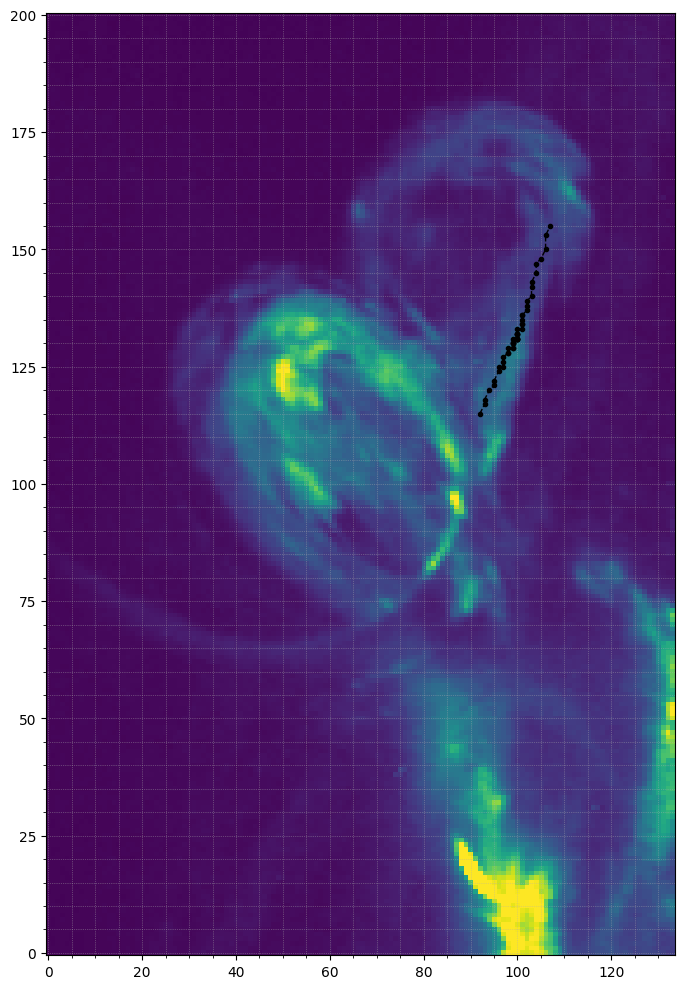

In [1440]:
def draw_cubic_bezier(x1=0, y1=0, x2=0, y2=0, control1=[0,0], control2=[0,0]):
    """
    Draw a Cubic Bézier curve using two control points.
    The curve will be drawn from the point (x1, y1) to the point (x2, y2) 
    using the control points control1 and control2.
    """
    # Convert points to numpy arrays
    P0 = np.array([x1, y1])  # Start point
    P1 = np.array(control1)   # First control point
    P2 = np.array(control2)   # Second control point
    P3 = np.array([x2, y2])   # End point

    # Create time steps t from 0 to 1
    t = np.linspace(0, 1, 50)  # 100 points for smoothness

    # Cubic Bézier formula: B(t) = (1 - t)^3 * P0 + 3*(1 - t)^2 * t * P1 + 3*(1 - t) * t^2 * P2 + t^3 * P3
    bezier_curve = (1 - t)[:, None] ** 3 * P0 + \
                   3 * (1 - t)[:, None] ** 2 * t[:, None] * P1 + \
                   3 * (1 - t)[:, None] * t[:, None] ** 2 * P2 + \
                   t[:, None] ** 3 * P3

    return bezier_curve

def extract_cubic_bezier_values(array, x1, y1, x2, y2, control1, control2):
    """
    Extract the values of a Cubic Bézier curve using two control points.
    The curve will be drawn from the point (x1, y1) to the point (x2, y2)
    using the control points control1 and control2.
    """
    bezier_curve = draw_cubic_bezier(x1, y1, x2, y2, control1, control2)
    
    # Get the x and y coordinates
    x_coords = np.round(bezier_curve[:, 0]).astype(int)
    y_coords = np.round(bezier_curve[:, 1]).astype(int)

    # Clip the coordinates to stay within array bounds
    x_coords = np.clip(x_coords, 0, array.shape[1] - 1)
    y_coords = np.clip(y_coords, 0, array.shape[0] - 1)

    # Extract values along the Bézier curve
    bezier_values = array[y_coords, x_coords]
    
    return bezier_values, x_coords, y_coords




# Example usage in your plot
m = map_objects[200] # loop_1: 177, loop_2: 200
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)
subimage = m_submap.data.astype(np.float64)

x1 = 92
y1 = 115
x2 = 107
y2 = 155
control1 = [105, 145] # First control point
control2 = [95, 115]  # Second control point

fig = plt.figure(figsize=[7,10])
ax = fig.add_subplot(111)
ax.imshow(subimage, origin='lower', vmin=0, vmax=4e2)

intens, x_coords, y_coords = extract_cubic_bezier_values(subimage, x1, y1, x2, y2, control1, control2)
ax.plot(x_coords, y_coords, 'ko--', linewidth=1, markersize=3)

ax.minorticks_on()
ax.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)
fig.tight_layout()
plt.show()

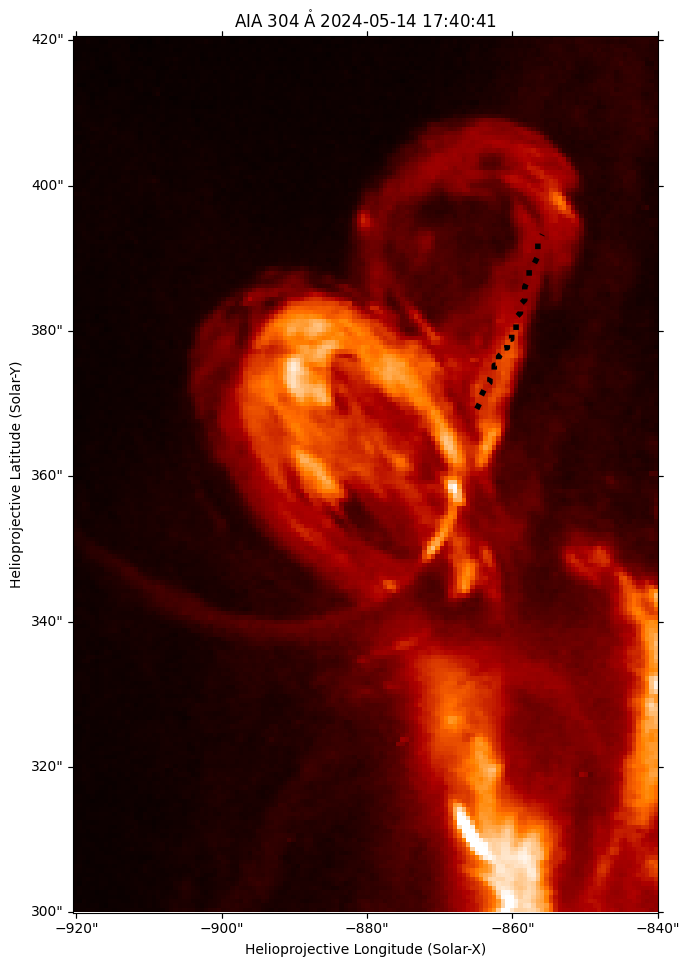

In [1441]:
# # FIRST segment -- to loop 1 --
# x1 = 80
# y1 = 110
# x2 = 10
# y2 = 80
# control1 = [97, 70]  # First control point
# control2 = [45, 60]  # Second control point

# # SECOND segment -- loop 1 --
# x1 = 80
# y1 = 110
# x2 = 50
# y2 = 90
# control1 = [55, 160]  # First control point
# control2 = [15, 125]  # Second control point

# THIRD segment -- bidge -- not set yet
x1 = 92
y1 = 115
x2 = 107
y2 = 155
control1 = [105, 145]  # First control point
control2 = [95, 115]   # Second control point

# # FOURTH segment -- loop 2 --
# x1 = 107
# y1 = 155
# x2 = 80
# y2 = 135
# control1 = [115, 195]  # First control point
# control2 = [45, 170]   # Second control point

intens, x_coords, y_coords = extract_bezier_values(subimage, x1, y1, x2, y2, control1, control2)

# convert pixel coordinates to world coordinates
slit = m_submap.pixel_to_world(x_coords * u.pixel, y_coords * u.pixel)

fig = plt.figure(figsize=[7,10])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)
ax.plot_coord(slit, color='k', ls=':', lw=4)
ax.grid(False)
fig.tight_layout()
plt.show()

In [1442]:
# track how intensity evolves along the slit over the sequence of solar images
time_array = []
intensity_stack = []

with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
    for m in map_objects:
        # extract the map time
        time_array.append(m.date.datetime)
        # crop the region of interest
        top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
        bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
        m_submap = m.submap(bottom_left, top_right=top_right)
        # convert the submap to an array
        subimage = m_submap.data.astype(np.float64)
        # extract the curved slit coords in pixels
        _, x_coords, y_coords = extract_bezier_values(subimage, x1, y1, x2, y2, control1, control2)
        # convert pixel coordinates to world coordinates
        slit = m_submap.pixel_to_world(x_coords * u.pixel, y_coords * u.pixel)
        # extract and stack intensity along the slit
        with SphericalScreen(m.observer_coordinate):
            slit_pixelated = sunpy.map.pixelate_coord_path(m_submap, slit)
        # slit_distance = slit_pixelated.separation(slit_pixelated[0])
        angular_distances = slit_pixelated[:-1].separation(slit_pixelated[1:])
        # Compute the cumulative sum of the angular distances
        cumulative_distances = np.cumsum(angular_distances)
        # Add 0 at the start to represent the distance at the first point
        cumulative_distances_with_start = np.insert(cumulative_distances, 0, 0*u.arcsec)
        # sample the intensity at those coords
        intensity = sunpy.map.sample_at_coords(m_submap, slit_pixelated)
        # interpolate intensity along angular distance
        f_interp = interp1d(cumulative_distances_with_start, intensity.value, fill_value='extrapolate', kind='linear')
        intensity_interp = f_interp(cumulative_distances_with_start)
        # add the intensity array to the list
        intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
        pbar.update(1)

# get the distance along slit in arcsec
distance = cumulative_distances_with_start.to(u.arcsec).value
concatenated_array = np.vstack(intensity_stack).value.T

Stack intensities ...: 100%|███████████████████████████████████████████████████████████████████| 592/592 [01:38<00:00,  6.03it/s]


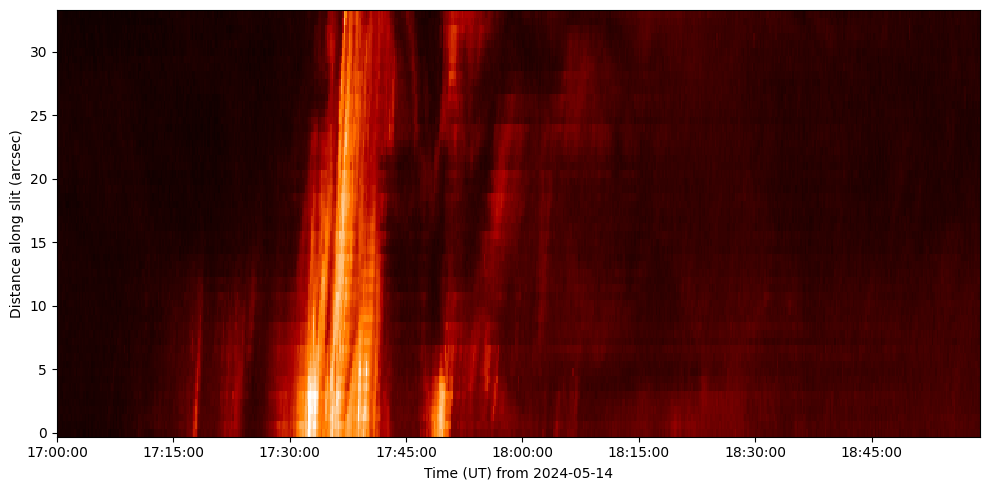

In [1443]:
fig, ax = plt.subplots(figsize=[10,5])
ax.pcolormesh(time_array,
              distance,
              concatenated_array,
              norm=ImageNormalize(vmin=0, vmax=400, stretch=AsinhStretch()),
              # norm=LogNorm(),
              cmap=sdoaia304
             )
ax.set_ylabel('Distance along slit (arcsec)')
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# ax.set_xlim(left=pd.Timestamp('2024-05-14 17:05:00'),
#            right=pd.Timestamp('2024-05-14 18:00:00'))

# ax.set_xlim(left=pd.Timestamp('2024-05-14 17:25:00'),
#            right=pd.Timestamp('2024-05-14 18:30:00'))

fig.tight_layout()
plt.show()

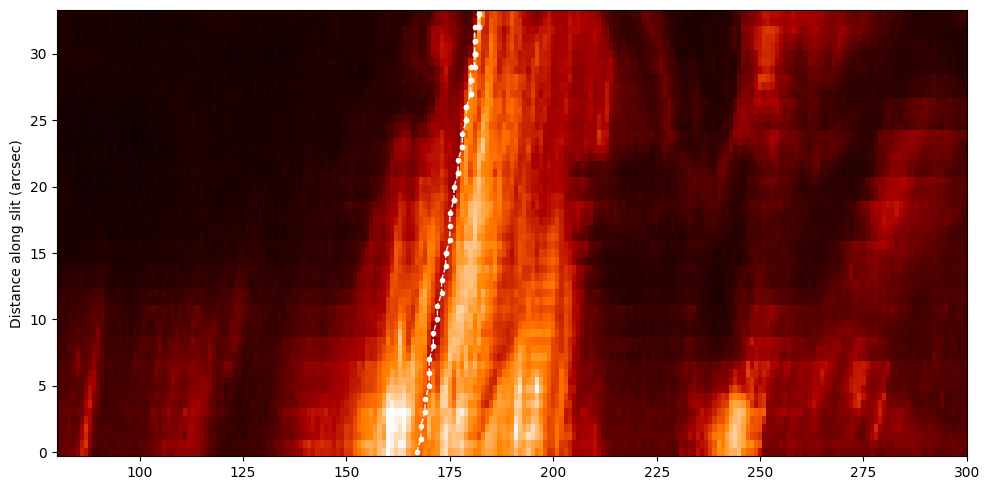

In [1460]:
x1 = 167
x2 = 182
y1 = distance[0]
y2 = distance[-1]
control = [180, 27]

fig, ax = plt.subplots(figsize=[10,5])
ax.pcolormesh(np.arange(concatenated_array.shape[1]),
              distance,
              concatenated_array,
              norm=ImageNormalize(vmin=0, vmax=400, stretch=AsinhStretch()),
              cmap=sdoaia304
             )
_, x_coords, y_coords = extract_quadratic_bezier_values(concatenated_array, x1, y1, x2, y2, control)
ax.plot(x_coords, y_coords, 'wo--', linewidth=1, markersize=3)
ax.set_ylabel('Distance along slit (arcsec)')
ax.set_xlim(left=80, right=300)
fig.tight_layout()
plt.show()

In [1461]:
df = pd.DataFrame({'time': np.array(time_array)[x_coords],
                   'distance': y_coords
                  })
df.head()

,time,distance
0,2024-05-14 17:33:53.130,0
1,2024-05-14 17:34:05.120,1
2,2024-05-14 17:34:05.120,2
3,2024-05-14 17:34:17.130,3
4,2024-05-14 17:34:17.130,4


In [1462]:
# get the radius of the solar disk
sol_rad = const.equatorial_radius.to(u.km)
print(sol_rad)

# conversion factor from arcsec to km
conversion_factor = sol_rad/m.rsun_obs

# convert distance from arcsec to km
df['distance_km'] = df['distance'] * conversion_factor.value

# calculate the distance difference in km
df['distance_diff_km'] = df['distance_km'].diff()

# calculate the time difference in seconds
df['time_diff_s'] = df['time'].diff().dt.total_seconds()

# calculate the speed in km/s
df['speed_km_s'] = df['distance_diff_km'] / df['time_diff_s']

df.head()

695700.0 km


,time,distance,distance_km,distance_diff_km,time_diff_s,speed_km_s
0,2024-05-14 17:33:53.130,0,0.00000,NaN,NaN,NaN
1,2024-05-14 17:34:05.120,1,732.64012,732.64012,11.99,61.104264
2,2024-05-14 17:34:05.120,2,1465.28024,732.64012,0.00,inf
3,2024-05-14 17:34:17.130,3,2197.92036,732.64012,12.01,61.002508
4,2024-05-14 17:34:17.130,4,2930.56048,732.64012,0.00,inf


In [1463]:
# drop the first row which will have NaN values for the differences
df.dropna(inplace=True)

# Filter out rows where time_diff_s is 0 and speed_km_s is inf
df = df[~((df['time_diff_s'] == 0) & (df['speed_km_s'] == np.inf))]
# Filter out rows where speed_km_s is zero
df = df[~(df['speed_km_s'] == 0)]

In [1464]:
max_speed = np.nanmax(df['speed_km_s'])
min_speed = np.nanmin(df['speed_km_s'])
avg_speed = np.nanmean(df['speed_km_s'])

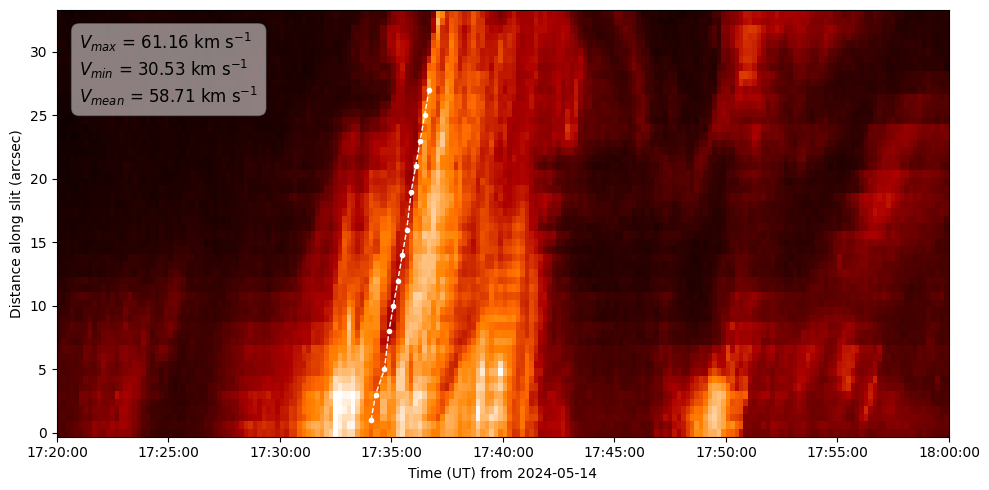

In [1470]:
fig, ax = plt.subplots(figsize=[10,5])
ax.pcolormesh(time_array,
              distance,
              concatenated_array,
              norm=ImageNormalize(vmin=0, vmax=400, stretch=AsinhStretch()),
              cmap=sdoaia304
             )
ax.plot(df['time'], df['distance'], 'wo--', linewidth=1, markersize=3)
        # label=rf'$V_{{max}}$ = {max_speed:.2f} km s$^{{-1}}$\n$V_{{min}}$ = {min_speed:.2f} km s$^{{-1}}$\n$V_{{mean}}$ = {avg_speed:.2f} km s$^{{-1}}$')

# Make a multi-line string with max, min, and mean speeds
# textstr = (rf'$V_{{max}} = {max_speed:.2f}\ \mathrm{{km\ s^{{-1}}}}$' + '\n'
#            rf'$V_{{min}} = {min_speed:.2f}\ \mathrm{{km\ s^{{-1}}}}$' + '\n'
#            rf'$V_{{mean}} = {avg_speed:.2f}\ \mathrm{{km\ s^{{-1}}}}$')

# OR ...
textstr = (rf'$V_{{max}}$ = {max_speed:.2f} km s$^{{-1}}$' + '\n'
           rf'$V_{{min}}$ = {min_speed:.2f} km s$^{{-1}}$' + '\n'
           rf'$V_{{mean}}$ = {avg_speed:.2f} km s$^{{-1}}$')

# Add the text to the plot using ax.text() at the desired location (x, y)
# loop 1: 0.025, 0.95
# loop 2: 0.77, 0.95
ax.text(0.025, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))

# ax.legend(loc='upper left')
ax.set_ylabel('Distance along slit (arcsec)')
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# ax.set_xlim(left=pd.Timestamp('2024-05-14 17:05:00'),
#            right=pd.Timestamp('2024-05-14 18:00:00'))

ax.set_xlim(left=pd.Timestamp('2024-05-14 17:20:00'),
           right=pd.Timestamp('2024-05-14 18:00:00'))

fig.tight_layout()
plt.show()

In [1419]:
df

,time,distance,distance_km,distance_diff_km,time_diff_s,speed_km_s
1,2024-05-14 17:37:17.130,1,732.64012,732.64012,12.00,61.053343
3,2024-05-14 17:37:29.120,3,2197.92036,732.64012,11.99,61.104264
5,2024-05-14 17:37:41.130,6,4395.84072,1465.28024,12.01,122.005016
7,2024-05-14 17:37:53.130,8,5861.12096,732.64012,12.00,61.053343
10,2024-05-14 17:38:05.130,11,8059.04132,732.64012,12.00,61.053343
12,2024-05-14 17:38:17.130,14,10256.96168,732.64012,12.00,61.053343
14,2024-05-14 17:38:29.140,16,11722.24192,732.64012,12.01,61.002508
17,2024-05-14 17:38:41.130,20,14652.80240,732.64012,11.99,61.104264
19,2024-05-14 17:38:53.130,23,16850.72276,1465.28024,12.00,122.106687
22,2024-05-14 17:39:05.120,26,19048.64312,732.64012,11.99,61.104264


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def draw_bezier(x1=0, y1=0, x2=0, y2=0, controls=[[0,0]], n=2):
    """
    Draw a Bézier curve of degree n using control points.
    
    Parameters:
    - x1, y1: Start point coordinates.
    - x2, y2: End point coordinates.
    - controls: A list of control points, where:
        - 1 control point for n=2 (quadratic).
        - 2 control points for n=3 (cubic).
    - n: Degree of the Bézier curve (2 for quadratic, 3 for cubic).
    
    Returns:
    - bezier_curve: An array of points [x, y] that form the Bézier curve.
    """
    if n == 2 and len(controls) != 1:
        raise ValueError("Quadratic Bézier requires exactly 1 control point.")
    elif n == 3 and len(controls) != 2:
        raise ValueError("Cubic Bézier requires exactly 2 control points.")
    
    # Convert points to numpy arrays
    P0 = np.array([x1, y1])  # Start point
    P3 = np.array([x2, y2])  # End point
    
    # Create time steps t from 0 to 1
    t = np.linspace(0, 1, 100)  # 100 points for smoothness

    if n == 2:  # Quadratic Bézier curve
        P1 = np.array(controls[0])  # Only 1 control point
        
        # Quadratic Bézier formula
        bezier_curve = (1 - t)[:, None] ** 2 * P0 + \
                       2 * (1 - t)[:, None] * t[:, None] * P1 + \
                       t[:, None] ** 2 * P3

    elif n == 3:  # Cubic Bézier curve
        P1 = np.array(controls[0])  # First control point
        P2 = np.array(controls[1])  # Second control point
        
        # Cubic Bézier formula
        bezier_curve = (1 - t)[:, None] ** 3 * P0 + \
                       3 * (1 - t)[:, None] ** 2 * t[:, None] * P1 + \
                       3 * (1 - t)[:, None] * t[:, None] ** 2 * P2 + \
                       t[:, None] ** 3 * P3

    return bezier_curve

def extract_bezier_values(array, x1, y1, x2, y2, controls, n):
    """
    Extract the values of a Bézier curve of degree n using control points.
    The curve will be drawn from the point (x1, y1) to the point (x2, y2)
    using the control points provided in the controls list.
    """
    bezier_curve = draw_bezier(x1, y1, x2, y2, controls, n)
    
    # Get the x and y coordinates
    x_coords = np.round(bezier_curve[:, 0]).astype(int)
    y_coords = np.round(bezier_curve[:, 1]).astype(int)

    # Clip the coordinates to stay within array bounds
    x_coords = np.clip(x_coords, 0, array.shape[1] - 1)
    y_coords = np.clip(y_coords, 0, array.shape[0] - 1)

    # Extract values along the Bézier curve
    bezier_values = array[y_coords, x_coords]
    
    return bezier_values, x_coords, y_coords

# Example usage in your plot
fig = plt.figure(figsize=[7,10])
ax = fig.add_subplot(111)
ax.imshow(subimage, origin='lower', vmin=0, vmax=4e2)

# Example for a quadratic Bézier curve (n=2, 1 control point)
control1 = [control_point1_x, control_point1_y]  # Single control point
_, x_coords, y_coords = extract_bezier_values(subimage, x1, y1, x2, y2, [control1], n=2)
ax.plot(x_coords, y_coords, 'bo--', linewidth=1, markersize=3)

# Example for a cubic Bézier curve (n=3, 2 control points)
control1 = [control_point1_x, control_point1_y]  # First control point
control2 = [control_point2_x, control_point2_y]  # Second control point
_, x_coords, y_coords = extract_bezier_values(subimage, x1, y1, x2, y2, [control1, control2], n=3)
ax.plot(x_coords, y_coords, 'ro--', linewidth=1, markersize=3)

plt.show()